In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats
from get_draws.api import get_draws

In [2]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_conic_lsff/v3.0_paf_of_one/ethiopia/2020_03_17_14_59_54/count_data/',
             '/ihme/costeffectiveness/results/vivarium_conic_lsff/v3.0_paf_of_one/india/2020_03_17_15_00_02/count_data/',
             '/ihme/costeffectiveness/results/vivarium_conic_lsff/v3.0_paf_of_one/nigeria/2020_03_17_15_00_10/count_data/']

locations = ['Ethiopia','India','Nigeria']

In [12]:
model_vad = pd.DataFrame()
for i in range(len(output_dirs)):
    overall_pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf').groupby(['age_group','sex','input_draw']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf').groupby(['age_group','sex','input_draw','vitamin_a_cat']).sum()
    data = pt/overall_pt
    data = data.reset_index().groupby(['age_group','sex','vitamin_a_cat']).describe().drop(columns='input_draw').reset_index() # cat 1 = exposed
    data['location'] = locations[i]
    model_vad = model_vad.append(data.where(data['vitamin_a_cat'] == 'cat1').dropna())
model_vad.head()

age_group     sex vitamin_a_cat value                                \
                                        count      mean       std       min   
0          1_to_4  female          cat1  25.0  0.316194  0.029712  0.268828   
2          1_to_4    male          cat1  25.0  0.319361  0.028968  0.256508   
4  early_neonatal  female          cat1  25.0  0.345832  0.030038  0.292967   
6  early_neonatal    male          cat1  25.0  0.352571  0.029938  0.281545   
8   late_neonatal  female          cat1  25.0  0.341025  0.029898  0.289112   

                                           location  
        25%       50%       75%       max            
0  0.291029  0.318193  0.335684  0.389112  Ethiopia  
2  0.297588  0.320390  0.334371  0.379799  Ethiopia  
4  0.320351  0.343755  0.362388  0.416663  Ethiopia  
6  0.337066  0.350457  0.366788  0.418314  Ethiopia  
8  0.315648  0.339381  0.357989  0.411596  Ethiopia

In [ ]:
# get means and LCLs, UCLs
gbd = (gbd_anemia.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
       .drop(columns=['count','std','min','max','50%'])
       .rename(columns={'2.5%':'lower','97.5%':'upper'}).reset_index())

In [15]:
gbd_vad = pd.DataFrame()
for i in ['india','nigeria','ethiopia']:
    art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/' + i + '.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
    data = art.load('risk_factor.vitamin_a_deficiency.exposure').reset_index()
    data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                               np.where(data['age_end'] == 1, 'post_neonatal',
                                        np.where(data['age_start'] == 1, '1_to_4', 
                                                'late_neonatal')))
    data['sex'] = np.where(data['sex'] == 'Male', 'male', 'female')
    data = (data.drop(columns=['age_start','age_end','year_start','year_end']).
            set_index(['location','sex','age_group','parameter']))
    data = (data.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
           .drop(columns=['count','std','min','max','50%'])
           .rename(columns={'2.5%':'lower','97.5%':'upper'}).reset_index())
    gbd_vad = gbd_vad.append(data.where(data['parameter'] == 'cat1').dropna())
gbd_vad.head()

,location,sex,age_group,parameter,mean,lower,upper
0,India,female,early_neonatal,cat1,0.786167,0.589327,0.923678
2,India,female,late_neonatal,cat1,0.745103,0.560261,0.871665
4,India,female,post_neonatal,cat1,0.454860,0.346680,0.534490
6,India,female,1_to_4,cat1,0.244279,0.202109,0.295549
8,India,male,early_neonatal,cat1,0.800800,0.607494,0.929971


In [34]:
avg = test.groupby(['age_group','sex','vitamin_a_cat'], as_index=False).mean()
avg = (avg.where(avg['vitamin_a_cat'] == 'cat1').dropna().drop(columns='input_draw')
       .rename(columns={'value':'model_prev', 'prev':'gbd_prev'}))
avg

,age_group,sex,vitamin_a_cat,model_prev,gbd_prev
0,1_to_4,female,cat1,0.246890,0.244279
2,1_to_4,male,cat1,0.256762,0.255485
4,early_neonatal,female,cat1,0.276575,0.786167
6,early_neonatal,male,cat1,0.286564,0.800800
8,late_neonatal,female,cat1,0.270360,0.745103
10,late_neonatal,male,cat1,0.279983,0.759674
12,post_neonatal,female,cat1,0.253124,0.454860
14,post_neonatal,male,cat1,0.262902,0.467091


In [46]:
model_vad = model_vad.reset_index().sort_values(by='location')
gbd_vad = gbd_vad.reset_index().sort_values(by='location')

In [60]:
# define plotting function
def make_vad_plots(age_group_1, age_group_2):
    barWidth = 0.3

    fig,axs = plt.subplots(2,2)

    model = model_vad['value','mean'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'male').dropna().values
    model_min = (model_vad['value','mean'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'male').dropna().values
                    - model_vad['value','min'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'male').dropna().values)
    model_max = (model_vad['value','max'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'male').dropna().values
                    - model_vad['value','mean'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'male').dropna().values)

    gbd = gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'male').dropna().values
    gbd_lower = (gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'male').dropna().values
                 - gbd_vad['lower'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'male').dropna().values)
    gbd_upper = (gbd_vad['upper'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'male').dropna().values
                 - gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'male').dropna().values)

    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
    axs[0,0].bar(b, model, yerr=[model_min, model_max], width=barWidth)
    axs[0,0].set_title(f'{age_group_1} Males')


    model = model_vad['value','mean'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'male').dropna().values
    model_min = (model_vad['value','mean'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'male').dropna().values
                    - model_vad['value','min'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'male').dropna().values)
    model_max = (model_vad['value','max'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'male').dropna().values
                    - model_vad['value','mean'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'male').dropna().values)

    gbd = gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'male').dropna().values
    gbd_lower = (gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'male').dropna().values
                 - gbd_vad['lower'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'male').dropna().values)
    gbd_upper = (gbd_vad['upper'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'male').dropna().values
                 - gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'male').dropna().values)

    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,1].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
    axs[0,1].bar(b, model, yerr=[model_min, model_max], width=barWidth)
    axs[0,1].set_title(f'{age_group_2} Males')

    model = model_vad['value','mean'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'female').dropna().values
    model_min = (model_vad['value','mean'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'female').dropna().values
                    - model_vad['value','min'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'female').dropna().values)
    model_max = (model_vad['value','max'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'female').dropna().values
                    - model_vad['value','mean'].where(model_vad['age_group'] == age_group_1).where(model_vad['sex'] == 'female').dropna().values)

    gbd = gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'female').dropna().values
    gbd_lower = (gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'female').dropna().values
                 - gbd_vad['lower'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'female').dropna().values)
    gbd_upper = (gbd_vad['upper'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'female').dropna().values
                 - gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_1).where(gbd_vad['sex'] == 'female').dropna().values)

    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
    axs[1,0].bar(b, model, yerr=[model_min, model_max], width=barWidth)
    axs[1,0].set_title(f'{age_group_1} Females')


    model = model_vad['value','mean'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'female').dropna().values
    model_min = (model_vad['value','mean'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'female').dropna().values
                    - model_vad['value','min'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'female').dropna().values)
    model_max = (model_vad['value','max'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'female').dropna().values
                    - model_vad['value','mean'].where(model_vad['age_group'] == age_group_2).where(model_vad['sex'] == 'female').dropna().values)

    gbd = gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'female').dropna().values
    gbd_lower = (gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'female').dropna().values
                 - gbd_vad['lower'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'female').dropna().values)
    gbd_upper = (gbd_vad['upper'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'female').dropna().values
                 - gbd_vad['mean'].where(gbd_vad['age_group'] == age_group_2).where(gbd_vad['sex'] == 'female').dropna().values)

    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[1,1].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
    axs[1,1].bar(b, model, yerr=[model_min, model_max], width=barWidth)
    axs[1,1].set_title(f'{age_group_2} Females')


    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=['India','Ethiopia','Nigeria'])

    for ax in axs.flat:
        ax.set(ylabel='Prevalence')

    plt.legend(['Impariment Prevalence','Model Prevalence'])
    plt.suptitle('VAD Prevalence',x=0.9, y=1.7,fontsize=20)
    plt.subplots_adjust(right=1.7, top=1.5)
    #plt.tight_layout()

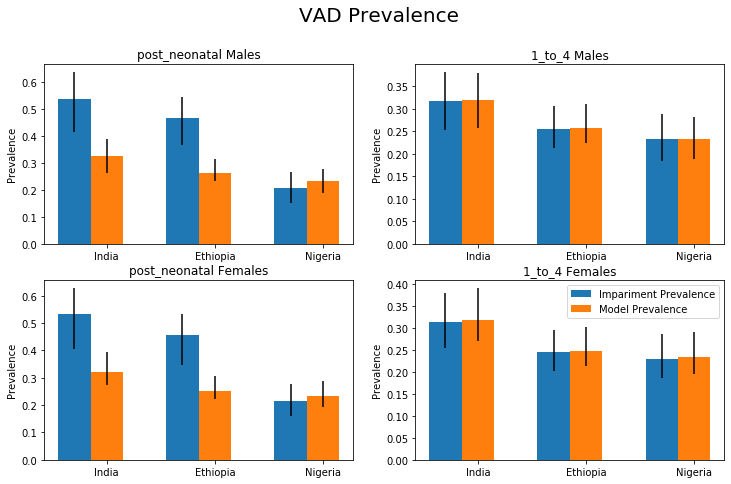

In [61]:
make_vad_plots('post_neonatal','1_to_4')

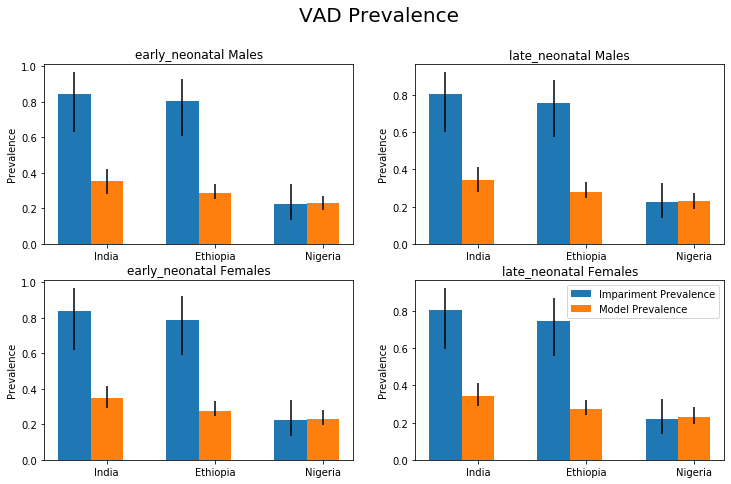

In [62]:
make_vad_plots('early_neonatal','late_neonatal')